In [10]:
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import colors
from matplotlib.ticker import MultipleLocator
import os.path
from pathlib import Path
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

from qbo1d import utils
from qbo1d import adsolver
from qbo1d import emulate
from qbo1d.stochastic_forcing import WaveSpectrum
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
t_max = 360 * 108 * 86400
nsteps = 360 * 108
nspinup = 360 * 12
ntot = int(nsteps - nspinup)

torch.set_default_dtype(torch.float64)


# scenario 0 (control)
# --------------------
solver = adsolver.ADSolver(t_max=t_max, w=3e-4)
model = WaveSpectrum(solver)
time = solver.time
z = solver.z
u = solver.solve(source_func=model)

# evaluate source
s = model.s
print(s.shape)
sf = model.sf
cw = model.cw

torch.Size([38881, 73])


* In the following code block, we put in "sf" and "cw"
* What we are going to do is to do the model $S  = S(u, sf, cw)$
* The new variable will be named $U = (u, sf, cw)$

In [3]:
U = torch.concat([u, sf.view(-1, 1), cw.view(-1, 1)], axis=1)
# Truncate U
s = model.s
U = U[nspinup:nsteps, :]
s = s[nspinup:nsteps, :]
# Here U is the features and s is the label

In [4]:
U_train, U_test, s_train, s_test = train_test_split(U, s, test_size=0.2, random_state=42)

In [5]:
reg = LinearRegression().fit(U_train, s_train)
print("The score of the linear regression", reg.score(U_test, s_test))

The score of the linear regression 0.8955258564747448


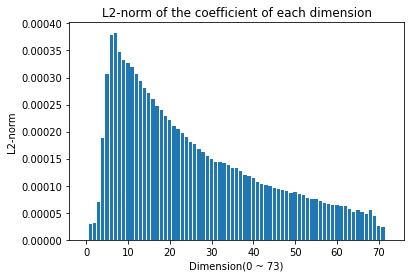

In [33]:
weights_of_each_dimension = np.array([np.linalg.norm(reg.coef_[:, i], 1) for i in range(reg.coef_.shape[1]-2)])
plt.bar(list(range(reg.coef_.shape[1]-2)),weights_of_each_dimension)
plt.xlabel("Dimension(0 ~ 73)")
plt.ylabel("L2-norm")
plt.title("L2-norm of the coefficient of each dimension")
plt.show()


In [7]:
print("The really significant bar is", weights_of_each_dimension.argmax())

The really significant bar is 73


### Things are a little bit wierd if we add a L2 regularization

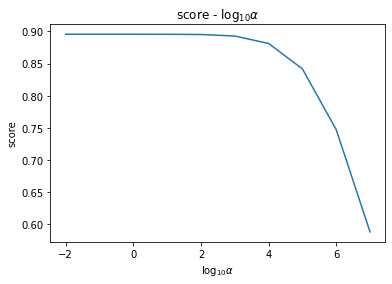

In [8]:
score_l2 = []
for i in range(-2, 8):
    l2_reg = Ridge(alpha=10**i).fit(U_train, s_train)
    score_l2.append(l2_reg.score(U_test, s_test))

plt.plot(list(range(-2, 8)), score_l2)
plt.xlabel(r"$\log_{10} \alpha$")
plt.ylabel("score")
plt.title(r"score - $\log_{10} \alpha$")
plt.show()

#### Then we visualize the weights

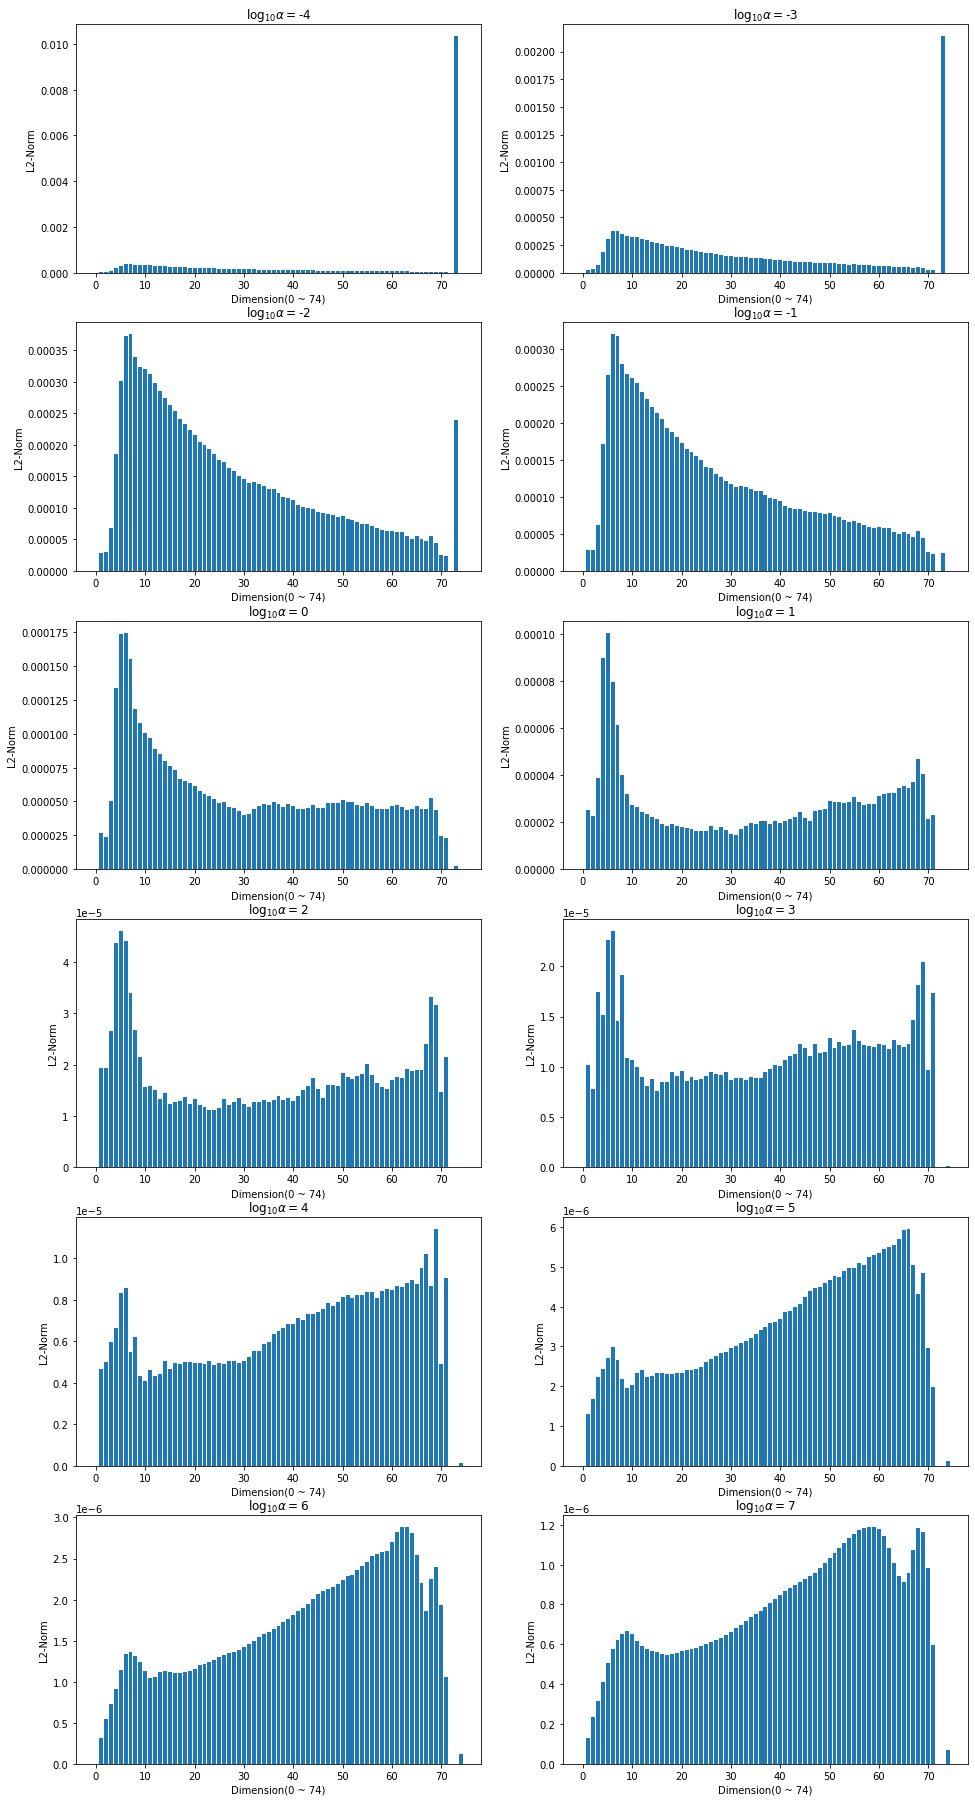

In [9]:
fig, axs = plt.subplots(6, 2)
fig.set_size_inches(16, 32)
for i in range(-4, 8):
    l2_reg = Ridge(alpha=10**i).fit(U_train, s_train)
    weights = np.array([np.linalg.norm(l2_reg.coef_[:, j], 1) for j in range(l2_reg.coef_.shape[1])])
    axs[(i+4)//2][(i+4)%2].bar(list(range(l2_reg.coef_.shape[1])), weights)
    axs[(i+4)//2][(i+4)%2].set_title(r"$\log_{10} \alpha = $" + str(i))
    axs[(i+4)//2][(i+4)%2].set_xlabel("Dimension(0 ~ 74)")
    axs[(i+4)//2][(i+4)%2].set_ylabel("L2-Norm")
    

### Some observations
* With the increasing of $\alpha$ the significance of last two entry are waning
* However, the score is not declining, which indicates there should be some overfitting.
* Also, the shift of the peak is relly interesting but confusing. 
* I believe there should be some physical reasons? 


### Let's do PCA

### TODO: Online
* we need the adsolver which takes sf and cw as inputs
* For now the inputs is merely $u$

<BarContainer object of 75 artists>

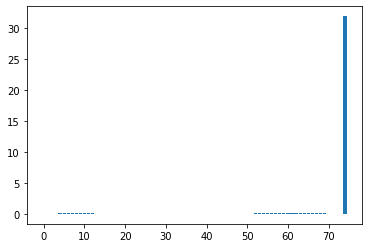

In [31]:
U.mean(axis=0).argmax()

tensor(74)

Here there's something really interesting...
* Most significant one 